In [2]:
%matplotlib inline

import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Introduction

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Predict_with_BN.ipynb and either compares predictions produced using different kinds of met data, or compares predictions to observations from the lake. 

In [3]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_era5_fpath = '../Data/Predictions/Historic/GBN_prediction_era5_1981-2019.csv'
sim_era5_av_fpath = '../Data/Predictions/Historic/GBN_prediction_era5-av_1981-2019.csv'
sim_s5_folder = '../Data/Predictions/Historic/s5'
sim_naive_fpath = '../Data/Predictions/Historic/Prediction_naive_1981-2019.csv'

out_folder = '../Hindcast_stats_plots'

var_list = ['TP','chla','colour','cyano']

In [4]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# Reformat obs to long format, same as the others
obs = pd.melt(obs_wide, id_vars=['year'], value_vars=var_list,
         var_name='node', value_name='obs')

obs.head()

,year,node,obs
0,1981,TP,28.833333
1,1982,TP,26.988095
2,1983,TP,29.781250
3,1984,TP,26.527500
4,1985,TP,30.957143


In [5]:
# Read in predictions driven by ERA5 met data ('pseudoobs') and reformat to same format as obs
sim_era5 = pd.read_csv(sim_era5_fpath)

# Pick out just the expected value
sim_era5_e = sim_era5[['year','node','expected_value']]
sim_era5_e.columns = ['year','node','sim_era5'] # Rename columns
sim_era5_e.head()

,year,node,sim_era5
0,1981,chla,19.20
1,1981,colour,28.80
2,1981,cyano,2.06
3,1981,TP,37.00
4,1982,chla,11.10


In [6]:
# Read in predictions driven by long-term average ERA5 met data and reformat to same format as obs
sim_era5_av = pd.read_csv(sim_era5_av_fpath)

# Pick out just the expected value
sim_era5_av_e = sim_era5_av[['year','node','expected_value']]
sim_era5_av_e.columns = ['year','node','sim_era5_av'] # Rename columns
sim_era5_av_e.head()

,year,node,sim_era5_av
0,1981,chla,19.00
1,1981,colour,28.90
2,1981,cyano,1.97
3,1981,TP,37.00
4,1982,chla,12.30


In [7]:
# Read in BN predictions driven by s5 and reformat

member_li = ["%.2d" % i for i in range(1,26)] # List of S5 member numbers in format '01','02'... Should be present in s5 met data folder
season_li = ['summer', 'late_summer'] # Seasons of interest (must match filenames in s5 met data folder)
st_yr = 1993
end_yr = 2019

sim_s5_dict = {} # key: season, returns df with cols yr, node, expected values from member 01, 02, 03,...
for season in season_li:
    expected_value_li = []
    for member in member_li:

        # Read in predictions for this season and member
        s5fname = 'GBN_prediction_s5_%s-%s_%s_%s.csv' %(st_yr, end_yr, season, member)
        s5fpath = os.path.join(sim_s5_folder, s5fname)
        sim_s5 = pd.read_csv(s5fpath)
        
        # Extract just the expected value, rename, and add to list
        expected_values = sim_s5['expected_value']
        expected_values.name = 'sim_s5_%s' %member
        expected_value_li.append(expected_values)
    
    # Make dataframe and add to expected values dict for s5
    sim_s5_e = pd.concat([sim_s5[['year','node']]]+expected_value_li, axis=1)
    sim_s5_dict[season] = sim_s5_e

# Check of output
sim_s5_dict['summer'].head()

,year,node,sim_s5_01,sim_s5_02,sim_s5_03,sim_s5_04,sim_s5_05,sim_s5_06,sim_s5_07,sim_s5_08,...,sim_s5_16,sim_s5_17,sim_s5_18,sim_s5_19,sim_s5_20,sim_s5_21,sim_s5_22,sim_s5_23,sim_s5_24,sim_s5_25
0,1993,chla,14.60,14.50,15.60,17.00,15.90,16.90,17.00,16.40,...,16.60,17.20,15.40,17.00,13.900,17.80,16.50,16.50,17.80,15.30
1,1993,colour,23.80,23.50,23.80,22.40,30.40,22.00,22.80,24.10,...,23.80,22.60,25.60,24.70,24.500,19.60,22.80,21.20,25.20,27.10
2,1993,cyano,1.08,1.07,1.28,1.65,1.16,1.65,1.64,1.44,...,1.51,1.71,1.19,1.58,0.945,2.02,1.53,1.56,1.77,1.12
3,1993,TP,29.90,29.90,29.90,29.90,29.90,29.90,29.90,29.90,...,29.90,29.90,29.90,29.90,29.900,29.90,29.90,29.90,29.90,29.90
4,1994,chla,12.60,14.10,14.90,14.90,14.00,13.40,12.90,15.40,...,15.00,14.40,13.20,15.60,13.700,11.20,13.80,15.50,13.50,12.60


In [8]:
# Calculate quantiles of interest of s5 from the 25 members

s5_quant_dict = {} # Key season, returns df with year, node, quantiles (0.025, 0.5, 0.975)
for season in season_li:
    s5_val_cols = sim_s5_dict[season].drop(['year','node'],axis=1).columns
    s5_quantiles = sim_s5_dict[season][s5_val_cols].quantile([0.025, 0.5, 0.975], axis=1).T
    s5_quantiles.columns = ['s5_%s_%s' %(str(i), season) for i in s5_quantiles]
    s5_quantiles[['year','node']] = sim_s5_dict[season][['year','node']]
    s5_quant_dict[season] = s5_quantiles
s5_quantiles.head()

,s5_0.025_late_summer,s5_0.5_late_summer,s5_0.975_late_summer,year,node
0,15.860,17.40,18.98,1993,chla
1,19.740,22.70,26.16,1993,colour
2,1.366,1.74,2.34,1993,cyano
3,29.900,29.90,29.90,1993,TP
4,11.780,13.40,15.04,1994,chla


In [9]:
# Predictions from simplest model - current season is equal to previous summer season
sim_naive_wide = pd.read_csv(sim_naive_fpath)

# Reformat obs to long format, same as the others
sim_naive = pd.melt(sim_naive_wide, id_vars=['year'], value_vars=var_list,
            var_name='node', value_name='sim_naive')

sim_naive.head()

,year,node,sim_naive
0,1981,TP,NaN
1,1982,TP,28.833333
2,1983,TP,26.988095
3,1984,TP,29.781250
4,1985,TP,26.527500


In [10]:
# Merge time series into a single df with cols obs and the different kind of simulations
df_li = [obs, sim_era5_e, sim_era5_av_e, sim_naive, s5_quant_dict['summer'], s5_quant_dict['late_summer']]
df = obs.copy().set_index(['year','node'])
for i, new_df in enumerate(df_li):
    new_df = new_df.set_index(['year','node'])
    if i>=1:
        df = df.join(new_df)

for season in season_li:
    df = df.drop(['s5_0.025_%s' %season,'s5_0.975_%s' %season], axis=1)
    
df = df.reset_index()
df.tail()

,year,node,obs,sim_era5,sim_era5_av,sim_naive,s5_0.5_summer,s5_0.5_late_summer
151,2015,cyano,0.233,0.337,0.456,0.283,0.517,0.394
152,2016,cyano,0.166,0.433,0.514,0.233,0.501,0.457
153,2017,cyano,0.258,0.241,0.271,0.166,0.296,0.278
154,2018,cyano,0.614,0.418,0.452,0.258,0.453,0.578
155,2019,cyano,0.592,0.369,0.413,0.614,0.440,0.416


# Time series

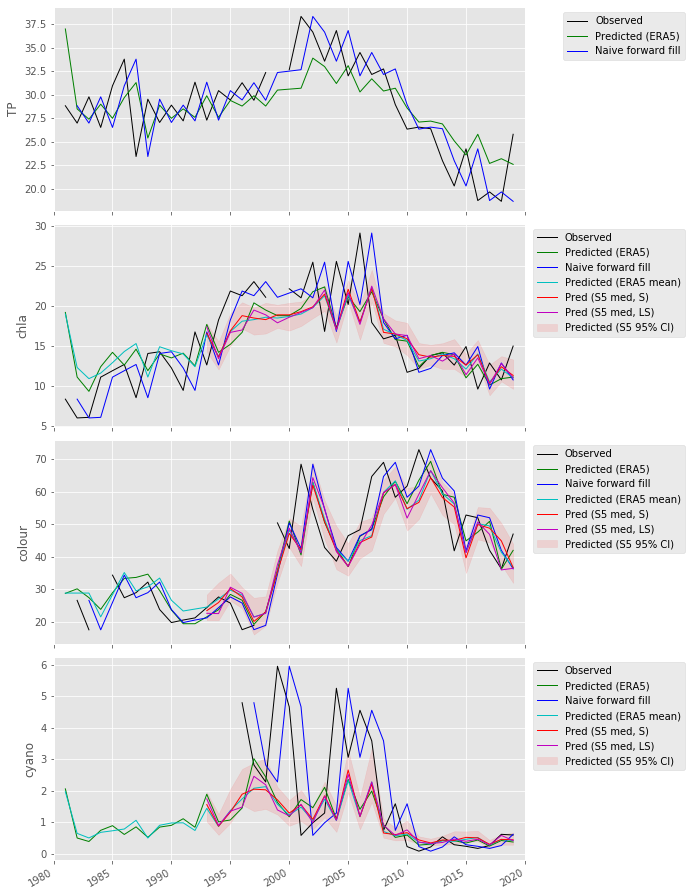

In [11]:
# Setup plot
fig, axes = plt.subplots(nrows=len(var_list), 
                         ncols=1, 
                         figsize=(10,15), 
                         sharex=True,
                        )

label_dict = {'obs':'Observed',
             'sim_era5':'Predicted (ERA5)',
             'sim_naive':'Naive forward fill',
             'sim_era5_av':'Predicted (ERA5 mean)',
             's5_0.5_summer': 'Pred (S5 med, S)',
             's5_0.5_late_summer': 'Pred (S5 med, LS)'}

colour_dict = {'obs':'k',
             'sim_era5':'g',
             'sim_naive':'b',
             'sim_era5_av':'c',
             's5_0.5_summer': 'r',
             's5_0.5_late_summer': 'm'}

# Loop over vars
for idx, var in enumerate(var_list):
    
    # Plot observations and predictions
    for col in label_dict.keys():
        if var == 'TP' and col not in ['obs','sim_era5','sim_naive']:
            pass
        else:
            var_series = df.loc[df['node'] == var, [col,'year']]
            var_series = var_series.set_index('year')

            axes[idx].plot(var_series.index, 
                           var_series.values, 
                           color=colour_dict[col], 
                           lw=1, 
                           label=label_dict[col]
                          )
    if var != 'TP':
        # Plot S5 95% CI. N.B. CI for summe and late summer are ~exactly the same, so only plot one
        s5_quantiles = s5_quant_dict['summer'].loc[s5_quant_dict['summer']['node'] == var]
        s5_quantiles = s5_quantiles.set_index('year')
        axes[idx].fill_between(s5_quantiles.index, 
                               s5_quantiles['s5_0.025_summer'], 
                               s5_quantiles['s5_0.975_summer'], 
                               color='r', 
                               alpha=0.1,
                               label='Predicted (S5 95% CI)',
                              )
    
    # Tidy
    axes[idx].set_ylabel(var)
    axes[idx].set_xlim(xmin=1980, xmax=2020)
    axes[idx].legend(bbox_to_anchor=(1.35, 1))
    
plt.tight_layout()
fig.autofmt_xdate()
plt.savefig(os.path.join(out_folder,'timeseries_gof.png'), dpi=200)

Using long-term mean weather from ERA5 as a constant input to the model gives almost exactly as good a prediction (compared to lake obs) as S5-driven predictions. i.e. S5 (or ERA5, for that matter) is no better than long-term average climate for any of my simulated variables. The model/lake is just too insensitive to weather, and very driven by the condition of the lake the previous year (and other things which probably aren't included in the model). On the plus, I have pretty good seasonal forecasting ability. Well, it's a result of sorts I guess...! Plenty to discuss in a paper anyway.

# Predictive correlation, rmse

In [12]:
df.tail()

,year,node,obs,sim_era5,sim_era5_av,sim_naive,s5_0.5_summer,s5_0.5_late_summer
151,2015,cyano,0.233,0.337,0.456,0.283,0.517,0.394
152,2016,cyano,0.166,0.433,0.514,0.233,0.501,0.457
153,2017,cyano,0.258,0.241,0.271,0.166,0.296,0.278
154,2018,cyano,0.614,0.418,0.452,0.258,0.453,0.578
155,2019,cyano,0.592,0.369,0.413,0.614,0.440,0.416


In [22]:
def gof_stats(df, sim_cols_of_interest, st_yr, end_yr=2019):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest
    Input:
        df: with columns 'year', 'node' (variable), 'obs', predicted values
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats    
    """
    gof_df_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        cc_li = []
        rmse_li = []
        bias_li = []
        
        for col in sim_cols_of_interest:
            
            cc = df_var['obs'].corr(df_var[col], method='pearson')
            rmse = np.sqrt(np.mean(((df_var[col] - df_var['obs']) ** 2)))
            bias = np.mean(df_var[col] - df_var['obs'])
            cc_li.append(cc)
            
            rmse_li.append(rmse)
            bias_li.append(bias)

        gof_df = pd.DataFrame(list(zip(cc_li, rmse_li, bias_li)),
                              columns = ['pearsons_cc','rmse','bias'], 
                              index = sim_cols)

        gof_df_dict[var] = gof_df

    gof_df = pd.concat(gof_df_dict.values(), keys=gof_df_dict.keys())
    
    return gof_df

In [23]:
# First, do for all columns for the period with overlapping data (i.e. 1993-2019)
sim_cols = list(label_dict.keys())[1:]
gof_df = gof_stats(df, sim_cols, 1993)
gof_df

pearsons_cc       rmse      bias
TP     sim_era5               0.829981   3.386997 -0.216658
       sim_naive              0.828263   3.233311  0.218956
       sim_era5_av            0.828426   3.396087 -0.208966
       s5_0.5_summer          0.829981   3.386997 -0.216658
       s5_0.5_late_summer     0.829981   3.386997 -0.216658
chla   sim_era5               0.646312   4.062168 -1.173142
       sim_naive              0.567125   4.710248  0.088736
       sim_era5_av            0.618034   4.194930 -1.315450
       s5_0.5_summer          0.612453   4.170417 -1.157757
       s5_0.5_late_summer     0.562341   4.385000 -1.176988
colour sim_era5               0.793938   9.607405 -1.721681
       sim_naive              0.770653  10.403518 -0.384721
       sim_era5_av            0.770466   9.982697 -1.921681
       s5_0.5_summer          0.771603  10.073724 -2.463989
       s5_0.5_late_summer     0.776901   9.967194 -2.160143
cyano  sim_era5               0.533812   1.783219 -0.762075
       sim_naive              0.563204   1.759581  0.182957
       sim_era5_av            0.624364   1.768410 -0.835742
       s5_0.5_summer          0.631419   1.736922 -0.792908
       s5_0.5_late_summer     0.550574   1.802418 -0.806742

In [27]:
gof_df = gof_stats(df, sim_cols, 1981)
gof_df

pearsons_cc      rmse      bias
TP     sim_era5        0.645049  3.655061 -0.044763
       sim_naive       0.714134  3.657585  0.086036
       sim_era5_av     0.641662  3.668598 -0.047395
chla   sim_era5        0.643381  4.212895 -0.062475
       sim_naive       0.679898  4.420565 -0.165372
       sim_era5_av     0.598643  4.408643 -0.062738
colour sim_era5        0.855752  8.588212 -0.471192
       sim_naive       0.834189  9.434254  0.107660
       sim_era5_av     0.837884  9.092561 -0.379526
cyano  sim_era5        0.533812  1.783219 -0.762075
       sim_naive       0.563204  1.759581  0.182957
       sim_era5_av     0.624364  1.768410 -0.835742

In [25]:
# Then for whole period where have naive predictions for a better comparison of naive, ERA5 and ERA5-av predictions,
# leaving out S5 (which only starts in 1993)
sim_cols = ['sim_era5','sim_naive','sim_era5_av']
gof_df = gof_stats(df, sim_cols, 1982)
gof_df

pearsons_cc      rmse      bias
TP     sim_era5        0.719494  3.452243 -0.266693
       sim_naive       0.714134  3.657585  0.086036
       sim_era5_av     0.715732  3.466959 -0.269396
chla   sim_era5        0.706703  3.877561 -0.357914
       sim_naive       0.679898  4.420565 -0.165372
       sim_era5_av     0.664889  4.109155 -0.352778
colour sim_era5        0.855752  8.588212 -0.471192
       sim_naive       0.834189  9.434254  0.107660
       sim_era5_av     0.837884  9.092561 -0.379526
cyano  sim_era5        0.533812  1.783219 -0.762075
       sim_naive       0.563204  1.759581  0.182957
       sim_era5_av     0.624364  1.768410 -0.835742